# HW4 - Text Classification

Student Name: Chunran Yao, Ze Chen

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, roc_auc_score
from scipy.sparse import coo_matrix, hstack
from gensim import models
import re
import gensim.parsing.preprocessing as preprocessing
import spacy


# import data

In [19]:
train = pd.read_csv("reddit_200k_train.csv", encoding = 'latin1', index_col = 'Unnamed: 0') 
test = pd.read_csv("reddit_200k_test.csv",encoding='latin1', index_col = 'Unnamed: 0')

In [20]:
train.head()

,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [21]:
test.head()

,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
1,"Hi Larpo_Nadar, your submission has been remov...",0,t3_74udg6,do15nly,1507377013,1509603985,True
2,"So out of every 10,000 children with autism wh...",8,t3_879uw5,dwc3dps,1522107010,1525623538,False
3,"When I was pregnant, I was warned against eati...",4,t3_5qo49s,dd1wtw2,1485686073,1486529379,False
4,Imagine if this find was the bug that eradicat...,14,t3_5qmr9c,dd0qpcr,1485618726,1486509114,True
5,Is it a myth that the math says it would take ...,0,t3_6wtiwg,dmb0sg4,1504050679,1504495504,False


In [114]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

# Data Exploration

## Distribution plot

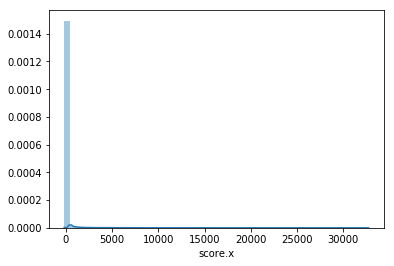

In [38]:
sns.distplot(X_train.iloc[:,1])

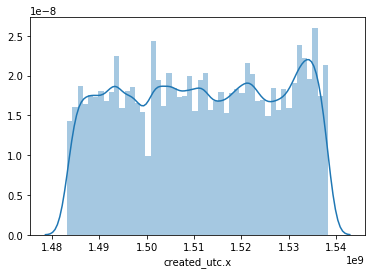

In [40]:
sns.distplot(X_train.iloc[:,4])

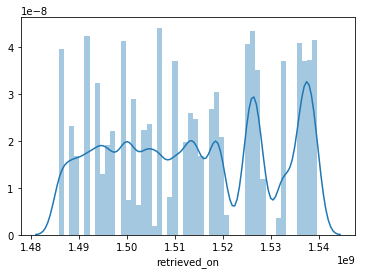

In [41]:
sns.distplot(X_train.iloc[:,5])

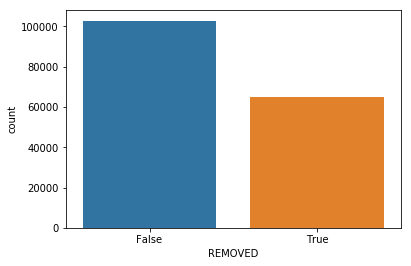

In [48]:
sns.countplot(y_train.iloc[:,0])

So it is imbalanced data, more False than True.

## Dependency plot

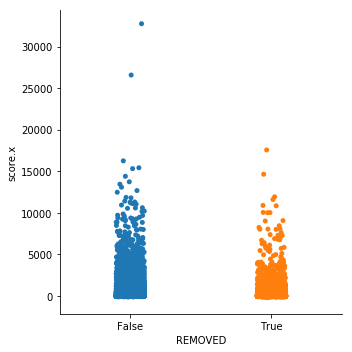

In [56]:
sns.catplot(y = "score.x", x = "REMOVED", data = train)

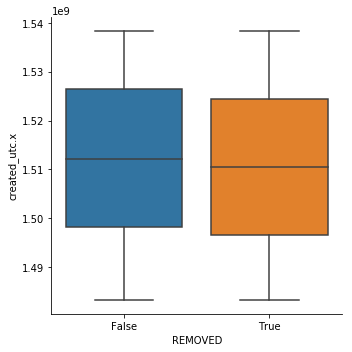

In [80]:
sns.catplot(y = "created_utc.x", x = "REMOVED",data = train, kind = 'box')

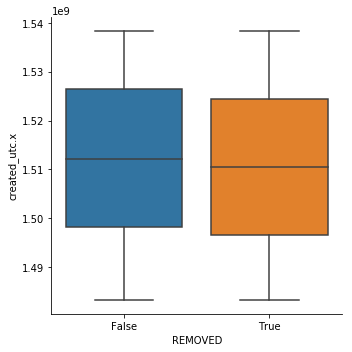

In [79]:
sns.catplot(y = "created_utc.x", x = "REMOVED", data = train, kind='box')

# Baseline Model: Bag of Words ad Logistic regression

In [86]:
X_train.head()

,body,score.x,parent_id.x,id,created_utc.x,retrieved_on
1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256
2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439
3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350
4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514
5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540


Since there are too much identical value in parent_id.x, created_utc.x and retrieved_on, and they doesn't show a strong correlation with target in data exploration, I don't use them in baseline model.       
I also use body and score.x.     
For text data, I use char_wb and tf-idf vectorizer, since it is best in previous analysis (in homework4.ipynb).   

In [84]:
continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'median')),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'constant', fill_value = 'missing')),('scaler', OneHotEncoder(handle_unknown = 'ignore'))])
text_transformer = Pipeline(steps = [('vectorizer', TfidfVectorizer(analyzer = 'char_wb',ngram_range = (2,3),stop_words = 'english'))])


In [108]:
preprocess = make_column_transformer((text_transformer,'body'),(continuous_transformer,['score.x']))

In [109]:
param_grid = {"logisticregression__C": [10, 1, 0.1, 0.01, 0.001]}
grid_baseline = GridSearchCV(make_pipeline(preprocess,LogisticRegression()),
                    param_grid=param_grid, cv=5, scoring="f1_macro" )

In [110]:
X_train_baseline = X_train.loc[:,['body','score.x']]

In [111]:
grid_baseline.fit(X_train_baseline, y_train)

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
     ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [112]:
grid_baseline.best_params_

{'logisticregression__C': 1}

In [113]:
grid_baseline.best_score_

0.6868108113855392

GridSearch above takes a long time, about half an hour.

Compare the best_score in homework4.ipynb, the score didn't improve a lot when adding score.x.

In [122]:
baseline_model = make_pipeline(preprocess,LogisticRegression(C = 1))
baseline_model.fit(X_train_baseline,y_train)
y_pred = baseline_model.predict(X_test.loc[:,['body','score.x']])

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
baseline_auc = roc_auc_score(y_pred,y_test)
baseline_auc

0.700700022221303

In [128]:
confusion_matrix(y_pred,y_test)

array([[28254,  9451],
       [ 6311, 11827]])

# Feature Engineering

In [ ]:
Explore Features by LASSO logistic coefficients

In [14]:
text_train_13 = text_train.copy()

In [15]:
lr_pipe = Pipeline(steps=[('cv',CountVectorizer()),
                          ('lr',LogisticRegression(penalty='l1'))])
lr_pipe.fit(text_train_lst, y_train)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [16]:
coef = lr_pipe.named_steps['lr'].coef_

In [17]:
feature_names = lr_pipe.named_steps['cv'].get_feature_names()

In [26]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()

    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)
    ax.set_title('Logistic Regression Coefficients')
    ax.set_ylabel('coefficients')
    ax.set_xlabel('feature')

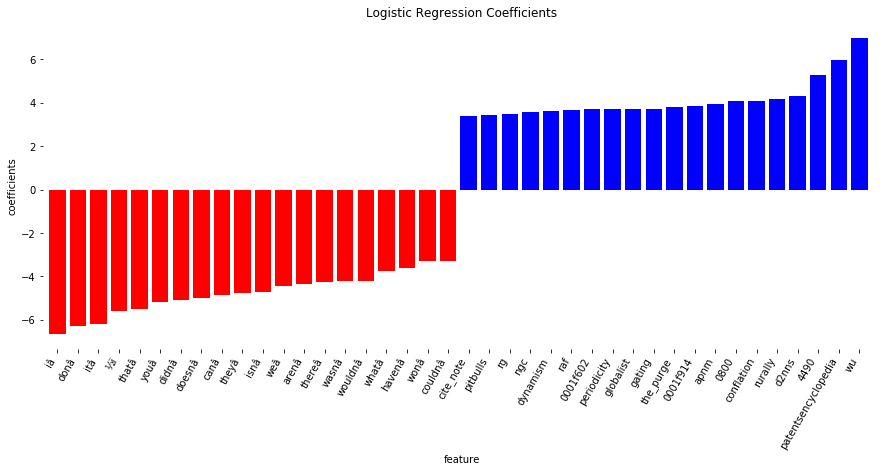

In [27]:
plt.figure(figsize=(15,6))
plot_important_features(coef.ravel(), np.array(feature_names),top_n=20, ax=None, rotation=60 )

In [28]:
pd.DataFrame({'feature name': feature_names, 
              'coefficient': coef.ravel().tolist()}).nlargest(20,'coefficient')

,feature name,coefficient
112178,wu,7.006169
78187,patentsencyclopedia,5.978584
8277,4490,5.288131
33420,d2nns,4.318528
89966,rurally,4.154242
30523,conflation,4.104860
1339,0800,4.078258
17561,apnm,3.945404
189,0001f914,3.833906
102253,the_purge,3.825181


In [29]:
pd.DataFrame({'feature name': feature_names, 
              'coefficient': coef.ravel().tolist()}).nsmallest(20,'coefficient')

,feature name,coefficient
58581,iâ,-6.648753
37765,donâ,-6.265144
58501,itâ,-6.210470
113699,½ï,-5.577377
102173,thatâ,-5.484909
113045,youâ,-5.162987
36057,didnâ,-5.086880
37557,doesnâ,-4.979570
25855,canâ,-4.872234
102622,theyâ,-4.764307


Use TfidfVectorizer to manipulate 'body' column

In [100]:
tfidf = TfidfVectorizer(analyzer="char_wb",ngram_range=(2,3),stop_words='english',token_pattern=r"\b\w+\b")
train = tfidf.fit_transform(text_train_lst)
train

<167529x77522 sparse matrix of type '<class 'numpy.float64'>'
	with 39879417 stored elements in Compressed Sparse Row format>

In [101]:
text_train['top20words'] = text_train.loc[:,'body'].str.contains('wu|patentsencyclopedia|d2nns|rurally|conflation|apnm|the_purge|gating|globalist|periodicity|raf|dynamism|ngc|rg|pitbulls|cite_note')

In [102]:
text_train['!count'] = text_train.loc[:,'body'].str.count('!') 

In [103]:
text_train['syb_count'] = text_train.loc[:,'body'].str.count('&|@|#|\\$|%|\\*|\\^') 

In [104]:
text_train['html'] = text_train.loc[:,'body'].str.contains('http:|html')
text_train['dirtywords'] = text_train.loc[:,'body'].str.contains('fuck|shit|damn|bitches')
text_train['@'] = text_train.loc[:,'body'].str.contains('@') 
text_train['!'] = text_train.loc[:,'body'].str.contains('!') 
text_train['length'] = text_train.loc[:,'body'].str.len()
#text_train = text_train.drop(columns=['body'])  

In [105]:
text_train.head()

,body,top20words,!count,syb_count,html,dirtywords,@,!,length
0,I've always been taught it emerged from the ea...,True,0,0,False,False,False,False,125
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",False,0,0,False,False,False,False,229
2,Monday: Drug companies stock dives on good new...,False,0,0,False,False,False,False,61
3,i learned that all hybrids are unfertile i won...,False,0,0,False,False,False,False,139
4,Well i was wanting to get wasted tonight. Not...,False,0,0,False,False,False,False,84


In [109]:
text_train = text_train.drop(columns=['body']) 

In [108]:
text_train[['html','dirtywords','@','!','top20words']] = (
    text_train[['html','dirtywords','@','!','top20words']]  == True).astype(int)
#text_train = coo_matrix(text_train)

**Scenario1: Combine ‘body' column and dereived features**

In [85]:
train = hstack([train,text_train])

In [86]:
param_grid = {"C": [1000,100,10, 1, 0.1, 0.01]}
grid = GridSearchCV(LogisticRegression(),param_grid=param_grid, cv=5, scoring="f1_macro" )

In [87]:
grid.fit(train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [90]:
grid.best_params_

{'C': 1}

In [91]:
grid.best_score_

0.6829471558880378

**Scenario 2: do not include 'body' column, only use derived feature**

In [111]:
text_train.head()

,top20words,!count,syb_count,html,dirtywords,@,!,length
0,1,0,0,0,0,0,0,125
1,0,0,0,0,0,0,0,229
2,0,0,0,0,0,0,0,61
3,0,0,0,0,0,0,0,139
4,0,0,0,0,0,0,0,84


In [112]:
param_grid = {"C": [1000,100,10, 1, 0.1, 0.01]}
grid = GridSearchCV(LogisticRegression(),param_grid=param_grid, cv=5, scoring="f1_macro" )

In [116]:
grid.fit(text_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [117]:
grid.best_params_

{'C': 1000}

In [118]:
grid.best_score_

0.4541557516222559

Use Gradient Boosting

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

In [120]:
param_grid = {"learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01]}
grid_gbdt = GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid, scoring="f1_macro" )

In [121]:
grid_gbdt.fit(text_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [122]:
grid_gbdt.best_params_

{'learning_rate': 1}

In [123]:
grid_gbdt.best_score_

0.5922428955492742

Comments:
    
'Body' column is important for classificantion when use logistic regression; If we drop body column and only use derived features, then gradient boosting perform much better than logistic regression for this problem.

## Task 2 Word Vector

In [92]:
for i in range(0,len(text_train_lst)):
    text_train_lst[i] = preprocessing.remove_stopwords(text_train_lst[i])
    text_train_lst[i] = preprocessing.strip_punctuation(text_train_lst[i])

In [93]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

**Word2vec pre-trained**

In [89]:
#use the GoogleNew dictionary
w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [94]:
#deal with the words not in w
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w.vocab:
            texts[i][j] = 'unknown'

In [95]:
 X_train = np.vstack([np.mean(w[doc], axis=0) for doc in texts])

In [104]:
param_grid = {"C": [10, 1, 0.1, 0.01, 0.001]}
grid_w2v = GridSearchCV(LogisticRegression(),param_grid=param_grid, cv=5, scoring="f1_macro")

In [105]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [106]:
grid_w2v.best_params_

{'C': 10}

In [107]:
grid_w2v.best_score_

0.6397384179079968

**Fasttext pre-trained crawl**

In [171]:
#use the crawl-300d-2M dictionary, fasetext pre-trained
#https://github.com/RaRe-Technologies/gensim/issues/814
w2 = models.KeyedVectors.load_word2vec_format('crawl-300d-2M.vec', binary=False)

In [182]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

In [184]:
#deal with the words not in w2
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w2.vocab:
            texts[i][j] = 'unknown'

In [185]:
 X_train = np.vstack([np.mean(w2[doc], axis=0) for doc in texts])

In [186]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [187]:
grid_w2v.best_params_

{'C': 10}

In [188]:
grid_w2v.best_score_

0.6568765489096293

**Fasttext pre-trained wiki-news with subword**

In [189]:
#use the wikipedia dictionary, fasetext pre-trained
w3 = models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M-subword.vec', binary=False)

In [190]:
texts = [[token for token in re.split('\W+',doc)] for doc in text_train_lst]

In [191]:
#deal with the words not in w2
for i in range(0, len(texts)):
    for j in range(0,len(texts[i])):
        if texts[i][j] not in w3.vocab:
            texts[i][j] = 'unknown'

In [192]:
 X_train = np.vstack([np.mean(w3[doc], axis=0) for doc in texts])

In [193]:
grid_w2v.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [194]:
grid_w2v.best_params_

{'C': 10}

In [195]:
grid_w2v.best_score_

0.6374199796830509

Comments

They tend to not have significant improvement for classification.